<div class="jumbotron">
  <h1><i class="fa fa-bar-chart" aria-hidden="true"></i>Inegeniría de características y trasnformaciones</h1>
  <p></p>
</div>


In [1]:
# ! pip install mlxtend

In [2]:
from os import chdir

# retroceder al directorio principal
chdir("..")

In [3]:
import pickle
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from pandas import DataFrame
from seaborn import boxplot
from pandas import get_dummies
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
from sklearn.model_selection import train_test_split


In [4]:
from src.utils.custom import remove_outliers_sigma,compute_outlier_bounds



### **Reglas de transformación derivadas del análisis**

1. **Normalización (Z-Score):**
   Se aplicará normalización mediante **Z-Score (StandardScaler)** a todas las variables numéricas. Esta técnica centra los datos en una media de 0 y una desviación estándar de 1, lo que permite comparar variables medidas en diferentes escalas (°C, %, ppm, lux).
   Se eligió esta transformación porque el **modelo baseline será una regresión logística**, la cual es sensible a las magnitudes relativas de las variables. Estandarizar mejora la estabilidad numérica y evita que las variables con mayor rango dominen los coeficientes.

2. **Interpretación de ceros en `light_lux`:**
   Los ceros representan ausencia real de luz (0 lux), no valores nulos, por lo que se conservarán sin imputación.

3. **Eliminación de variables redundantes:**
   Se eliminará `humidity_ratio` por su alta correlación con `humidity_percent` y su menor capacidad de discriminación observada en los boxplots.

4. **Balanceo de clases:**
   El balanceo se aplicará **solo a nivel de spliteo**:

   * **Entrenamiento y prueba:** conjuntos balanceados entre clases.
   * **Validación:** se mantiene la proporción original de clases.

5. **Split temporal:**
   Se mantendrán los patrones de días y horas al dividir el dataset. Se identificarán tres tipos de días:

   * Días sin muestras de actividad.
   * Días con pocas muestras de actividad.
   * Días con alta actividad (aprox. 60–40).
     Los splits se organizarán de forma cronológica (por fecha y hora).

6. **Tratamiento de outliers:**
   Se aplicará una estrategia basada en la **desviación estándar** (valores fuera de ±3σ serán considerados atípicos).

7. **Transformación de sesgo:**
   No se aplicarán transformaciones adicionales (log o similares), ya que el objetivo de esta etapa es evaluar el rendimiento del **modelo baseline sin optimización**.

8. **Variables temporales:**
   No se incluirán en esta iteración, debido a que el rango temporal disponible no permite verificar patrones recurrentes.

9. **Iteraciones futuras:**
   En fases posteriores, se evaluará la incorporación de transformaciones adicionales y variables derivadas del tiempo, según la estabilidad del modelo y la disponibilidad de nuevos datos.


In [5]:
# Load data (deserialize)
with open('data/interim/processing.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [6]:
df.dtypes

co2_ppm                       float64
humidity_percent              float64
humidity_ratio                float64
light_lux                     float64
class                        category
temperature_celsius           float64
timestamp              datetime64[ns]
day                            object
hour_num                        int32
hour_str                       object
date                           object
dtype: object

### Seleccionar Features Finales

In [7]:
df=df[[
    'co2_ppm',
    'humidity_percent',
    'class',
    'temperature_celsius',
    'date',
    'timestamp'
      ]]

In [8]:
# Definir etiqueta
etiqueta = 'class'

# Columnas numéricas
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Columnas no numéricas (excluye numéricas y la etiqueta)
time_features = ['timestamp']



### **Estrategia de segmentación temporal y balanceo**

Durante el análisis exploratorio se identificaron dos posibles escenarios para dividir los datos disponibles:

1. **Escenario A:** agrupar **cuatro días** para entrenamiento y prueba, dejando **dos días** para validación.
2. **Escenario B:** agrupar los **seis días disponibles** en **tres grupos diferenciados** según el comportamiento de la clase.

El **Escenario A** parecía más simple en términos de proporción temporal, pero resultaba inadecuado tras revisar la distribución de clases:
en algunos días la clase 1 prácticamente no está presente (0 %), mientras que en otros representa cerca del 40 % del total de observaciones.
Este desbalance natural entre días introduce un sesgo fuerte si se realiza el split directamente por número de días, ya que el modelo entrenaría sin ejemplos suficientes de una de las clases en ciertos periodos.

Por este motivo, se opta por el **Escenario B**, que conserva la estructura temporal y al mismo tiempo permite un balance controlado de clases.

---

### **Implementación seleccionada**

El procedimiento consiste en **tomar muestras balanceadas** provenientes de los tres tipos de días identificados:

* **Grupo A:** días sin muestras de clase 1 (≈ 0 %).
* **Grupo B:** días con pocas muestras de clase 1 (≈ 5 %).
* **Grupo C:** días con alta proporción de clase 1 (≈ 40 %).

De cada grupo se extrae una cantidad equivalente de ejemplos de ambas clases, conformando así un conjunto **balanceado** para el entrenamiento y prueba (train + test).
El resto de las observaciones se reservará para la **validación**, manteniendo sus proporciones originales para evaluar el desempeño del modelo bajo condiciones reales.

Una vez conformados los conjuntos, se aplica **normalización Z-Score** exclusivamente sobre los datos de entrenamiento.



### 1. Proporción global de clases

In [9]:
proporciones_globales = df['class'].value_counts(normalize=True)
print("Proporción global del dataset:")
print(proporciones_globales)

Proporción global del dataset:
class
0    0.78767
1    0.21233
Name: proportion, dtype: float64


### 2. Separación temporal de los 7 días

In [10]:
# El DataFrame ya viene ordenado por fecha y hora
dias_unicos = df['date'].unique()

In [11]:
# Primeros 4 días -> entrenamiento y test
dias_train_test = dias_unicos[:4]

# Últimos 3 días -> validación
dias_validacion = dias_unicos[4:]

df_train = df[df['date'].isin(dias_train_test)].copy()
df_valid = df[df['date'].isin(dias_validacion)].copy()

In [12]:
del df_train['date']
del df_valid['date']

### Número de muestras

In [13]:
df_train.shape

(4689, 5)

### Proporcion de clases

<Axes: title={'center': 'Distribución de clases en df_train_test'}, xlabel='class'>

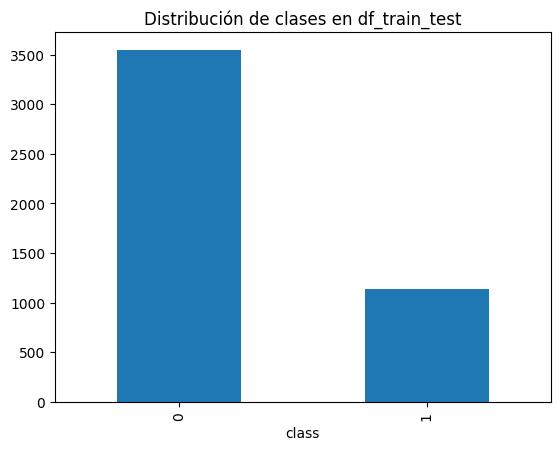

In [14]:
df_train['class'].value_counts().sort_index().plot(
    kind='bar',
    title='Distribución de clases en df_train_test'
)

El conjunto de entrenamiento mantiene la proporción real inicial, pero luego se balancea al 50/50 mediante sobremuestreo de la clase minoritaria. Esto evita que el modelo aprenda sesgos hacia la clase mayoritaria.

In [15]:
from sklearn.utils import resample

df_majority = df_train[df_train['class'] == 0]
df_minority = df_train[df_train['class'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_train_balanced = pd.concat([df_majority, df_minority_upsampled])
df_train_balanced = df_train_balanced.reset_index(drop=True)


ahora se ve así la proporcion de clases

<Axes: title={'center': 'Distribución de clases en df_train_test'}, xlabel='class'>

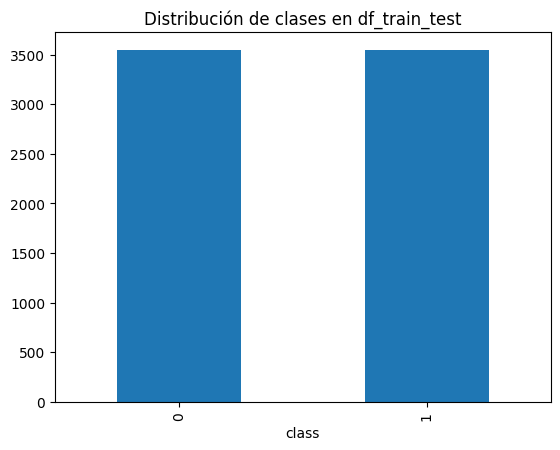

In [16]:
df_train_balanced['class'].value_counts().sort_index().plot(
    kind='bar',
    title='Distribución de clases en df_train_test'
)

In [17]:
df_train_balanced.shape

(7096, 5)

### Dataset de validacion

* La proporción original del dataset se mantiene tanto en el conjunto de validación, por el momento se conserva este enfoque sin aplicar ajustes adicionales.


<Axes: title={'center': 'Distribución de clases en df_train_test'}, xlabel='class'>

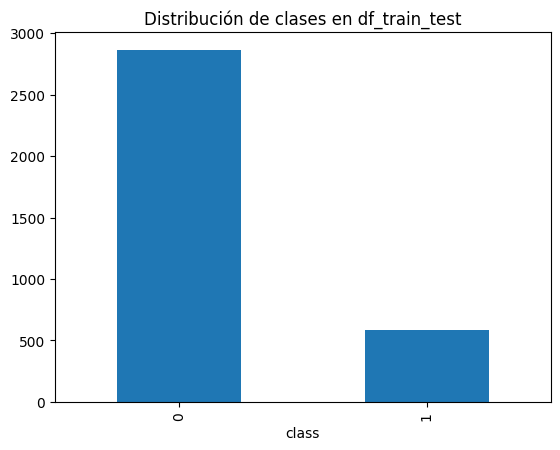

In [18]:
df_valid['class'].value_counts().sort_index().plot(
    kind='bar',
    title='Distribución de clases en df_train_test'
)

In [19]:
df_valid = df_valid.reset_index(drop=True)

In [20]:
df_valid.shape

(3454, 5)

In [21]:
import pickle

with open('data/interim/df_train.pickle', 'wb') as handle:
    pickle.dump(df_train, handle)

with open('data/interim/df_valid.pickle', 'wb') as handle:
    pickle.dump(df_valid, handle)

with open('data/interim/df_train_balanced.pickle', 'wb') as handle:
    pickle.dump(df_train_balanced, handle)


In [22]:
df_train

,co2_ppm,humidity_percent,class,temperature_celsius,timestamp
0,721.2,27.3,1,23.2,2015-02-04 17:51:00
1,714.0,27.3,1,23.1,2015-02-04 17:51:59
2,713.5,27.2,1,23.1,2015-02-04 17:53:00
3,708.2,27.2,1,23.1,2015-02-04 17:54:00
4,704.5,27.2,1,23.1,2015-02-04 17:55:00
...,...,...,...,...,...
4684,436.7,29.4,0,19.6,2015-02-07 23:55:00
4685,432.0,29.4,0,19.6,2015-02-07 23:55:59
4686,438.0,29.4,0,19.6,2015-02-07 23:57:00
4687,440.7,29.4,0,19.6,2015-02-07 23:57:59


### Spliteo

In [23]:
# Separar variables predictoras y target
X = df_train_balanced.drop(columns=['class'])
y = df_train_balanced['class']

# Spliteo balanceado (si aplica)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# reset index
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [24]:
y_test.shape

(1420,)

In [25]:
X_train.head()

,co2_ppm,humidity_percent,temperature_celsius,timestamp
0,665.3,19.7,21.3,2015-02-06 13:15:59
1,463.0,25.4,21.2,2015-02-04 23:29:00
2,1110.0,27.1,22.2,2015-02-05 12:01:00
3,1085.0,27.6,22.5,2015-02-05 15:30:59
4,440.5,19.2,19.8,2015-02-07 03:35:00


# Datos átipicos

In [26]:
bounds = compute_outlier_bounds(X_train, numeric_features, num_sigma=2)

# 2. Eliminar outliers del conjunto de entrenamiento
for var, lims in bounds.items():
    X_train = remove_outliers_sigma(X_train, var, lims['upper'], lims['lower'])
    y_train = y_train[X_train.index]

# 3. Aplicar los mismos límites al test (sin recalcular)
for var, lims in bounds.items():
    X_test = remove_outliers_sigma(X_test, var, lims['upper'], lims['lower'])
    y_test = y_test.loc[X_test.index]

# 4. Guardar límites para reproducibilidad
with open('models/outliers/outlier_bounds.pkl', 'wb') as f:
    pickle.dump(bounds, f)

In [27]:
len(X_train.index)

5629

In [28]:
X_train.shape , y_train.shape

((5629, 4), (5629,))

In [29]:
# Guardamos ya sin datos atípicos
with open('data/interim/X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle)

with open('data/interim/X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle)

with open('data/interim/y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle)

with open('data/interim/y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle)

# Z-score

In [30]:
# Escalar numéricas
z_score_scaler = StandardScaler()
X_train_scaled_numeric = pd.DataFrame(
    z_score_scaler.fit_transform(X_train[numeric_features]),
    columns=numeric_features,
    index=X_train.index
)
X_test_scaled_numeric = pd.DataFrame(
    z_score_scaler.transform(X_test[numeric_features]),
    columns=numeric_features,
    index=X_test.index
)

# Concatenar con columnas de tiempo sin cambios
X_train_scaled = pd.concat([X_train_scaled_numeric, X_train[time_features]], axis=1)
X_test_scaled = pd.concat([X_test_scaled_numeric, X_test[time_features]], axis=1)


In [31]:
with open('models/scalers/z_score_scaler.pkl', 'wb') as handle:
    pickle.dump(z_score_scaler, handle)

# Store data

In [32]:
with open('data/interim/X_train_scaled.pickle', 'wb') as handle:
    pickle.dump(X_train_scaled, handle)

with open('data/interim/X_test_scaled.pickle', 'wb') as handle:
    pickle.dump(X_test_scaled, handle)

with open('data/interim/y_train_scaled.pickle', 'wb') as handle:
    pickle.dump(y_train, handle)

with open('data/interim/y_test_scaled.pickle', 'wb') as handle:
    pickle.dump(y_test, handle)
    

In [33]:
X_train_scaled


,co2_ppm,humidity_percent,temperature_celsius,timestamp
0,-0.034203,-0.822383,-0.019005,2015-02-06 13:15:59
1,-0.888762,0.968322,-0.130560,2015-02-04 23:29:00
2,1.844306,1.502392,0.984983,2015-02-05 12:01:00
3,1.738700,1.659472,1.319646,2015-02-05 15:30:59
4,-0.983806,-0.979462,-1.692319,2015-02-07 03:35:00
...,...,...,...,...
5671,0.547472,-0.602472,0.427212,2015-02-06 12:01:00
5672,0.732492,-0.445392,0.427212,2015-02-06 10:59:59
5673,-0.072643,-0.916631,0.204103,2015-02-06 13:38:00
5674,-1.026049,-1.105126,-0.911439,2015-02-06 04:08:59
